# Exercise 04): Monte-Carlo Methods

In this exercise we make use of the racetrack environment (racetrack_environment.py) to test Monte-Carlo methods.

The racetrack environment is based on the OpenAI Gym interface (https://gymnasium.farama.org/) depicted in the picture below.

![](RL_GYM_racetrack.png)

(Source: Wiki, https://www.vecteezy.com/free-vector/car)

The agent can send an action to the system - our racetrack env - using the `env.step(action)` function to drive the car in the environment which is given by the following racetrack:

![](Racetrack1.png)

Here, the red line represents the start line and the goal is to move the car within the yellow course to the white finish line without hitting the wall.
If the car hits the wall, it must be returned to the starting line.
The information we get from the step function of the environment are
- state consisting of the y- and x-postion (`p_y` and `p_x`) and the velocity in x- and y-direction (`v_y` and `v_x`),
- `reward`, which will be -1 per step,
- `terminated`-flag which indicates if the environment is terminated (in our case if the car has reached the finish line),
- `truncated`-flag which is a termination condition outside of the MDP scope, e.g. timelimit, (in our case hitting a wall before the car has reached the finish line),
- info (addioninal information, not used here).

Our possible actions are to accelerate (positive acceleration) or break (negative acceleration) the car in x- and/or y-direction or do nothing.

Accelerating the car will result in changing the velocity of the car as follows:

![](Beschleunigen.png)

Breaking the car will result in changing the velocity of the car as follows:

![](break.png)

Our possible action-space is therefore `[-1, 0, 1]` which are availabe as tuple or integer number and encoded as explained later on.

Actions are encoded from a single integer (`a`) to the tuple (`a_y`, `a_x`) using the following equations:

- `a_y = a//3-1` (Floor division)
- `a_x = a%3-1` (Modulus)

This is shown in the following diagram:

![](Direction_endcoding.png)

Please make yourself more familiar with the used environment (racetrack_environment.py) for more information.

For the start, please execute the following cells.


In [17]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/CAS_AML_RL/lecture_related/solutions/day1/ex04')  # Add the parent directory to the path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
!pip install swig
!pip install "gymnasium[box2d]"
import gymnasium as gym
env = gym.make("CarRacing-v3", domain_randomize=True)

import numpy as np
import random
from racetrack_environment import RaceTrackEnv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm.notebook import tqdm
plt.style.use('dark_background')

Execute the following cells to build a race track using the `RaceTrackEnv` as a test scenario.  

In [19]:
from utils import build_uturn_course

WWWWWWWWWWWW
WWWWW-oooooW
WWWWW-oooooW
WWWWW-oooooW
WWWWWWWWWooW
WWWWWWWWWooW
WWWWW+oooooW
WWWWW+oooooW
WWWWW+oooooW
WWWWWWWWWWWW


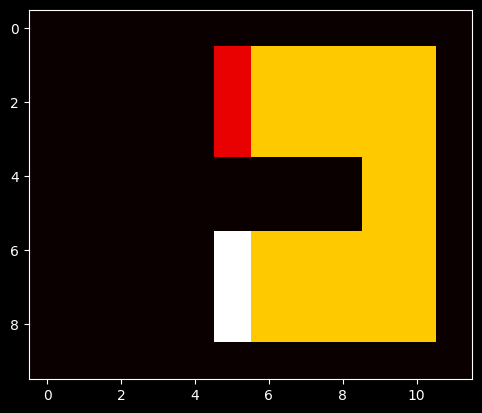

In [20]:
# Build the course
_course_dim = (8, 10)
_inner_wall_dim = (2, 6)

course = build_uturn_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)
for row in course:
    print(row)

pos_map = track.course  # overlay track course
plt.imshow(pos_map, cmap='hot', interpolation='nearest')
plt.show()

## 1) Monte-Carlo-Based Prediction (Policy Evaluation)

Write a first-visit Monte-Carlo algorithm to evaluate the dummy policy as defined below on the U-turn course. The dummy policy turns the car to the right as soon as it stands in front of a wall. Try to understand how the policy works before you start to code.
Think about what the different dimensions of the policy array encode. It might be helpful to print parts of the array for visualization.

How can we interprete the state values resulting from the evaluation with first-visit Monte-Carlo?

In [21]:
# Select course and initialize dummy policy

course = build_uturn_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)
dummy_slow_pi = np.ones([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY]) * 4

dummy_slow_pi[:track.bounds[0]//2, :, 0 , 0] = 5  # accelerate right
dummy_slow_pi[:track.bounds[0]//2, -2:, 0, :] = 6  # accelerate bottom left
dummy_slow_pi[-2:, track.bounds[1]//2:, :, 0] = 0  # accelerate top left

pi = dummy_slow_pi

## 1) Solution

The simple and deterministic dummy policy will always guarantee the car to reach the finish line. Thus, the state values can be interpreted as the number of timesteps that is necessary to reach the goal from that specific state (i.e. position and velocity) if we are following the policy.

In simple words, the policy acts as follows:
- ```dummy_slow_pi[:track.bounds[0]//2, :, 0, 0] = 5```: This part of the policy accelerates the car to the right when it is located anywhere in the upper half of the track bounds (first two dimensions) and has no velocity, i.e. is standing still (last two dimensions). This means that this part of the policy accelerates the car to a maximum velocity of ```v_x = 1```. As the car is not affected by this after it is already moving.
- ```dummy_slow_pi[:track.bounds[0]//2, -2:, 0, :] = 6```: This part of the policy takes effect when the car is in the upper half of the right boundary of the track. It only affects the car, when there is no vertical velocity (3rd dimension). As the car reaches this area of the space with the velocity ```v_x = 1``` and ```v_y = 0```, the velocity is ```v_x = 0``` and ```v_y = 1``` after this part of the policy was applied once.
- ```dummy_slow_pi[-2:, track.bounds[1]//2:, :, 0] = 0```: This part of the policy takes effect when the car is at the right half of the lower boundary of the track. It only affects the car, when there is no horizontal velocity (4th dimension). As the car reaches this area of the space with the velocity ```v_x = 0``` and ```v_y = -1```, the velocity is ```v_x = -1``` and ```v_y = 0``` after this part of the policy was applied once.

Overall, we can see that the absolute value of the car's velocity never goes above 1. While this makes the movement of the car manageable, this is not the fastest way to get through the track.

In [22]:
# Function templates to help structure the code, these (and similar ones) will be used in future exercises as well
# Note that the environment/track is a global variable here, so it does not need to be passed as an argument
# This is not a good practice in general, but it is done here to simplify the code
# You can therefore use the track variable directly in the functions
# e.g., track.reset()

def interact(pi, state):
    """Interact with the environment to get to the next state.

    Args:
        pi: The policy to follow
        state: The current state before interaction

    Returns:
        next_state: The next state after interaction
        reward: The reward for the current interaction
        terminated: If the goal was reached
        truncated: If the boundary of the track was breached
    """

    action = track.action_to_tuple(pi[state])
    next_state, reward, terminated, truncated, _ = track.step(action)

    return next_state, reward, terminated, truncated


def gather_experience(pi, max_epsiode_len):
    """Simulate a full episode of data by repeatedly interacting with the environment.

    End the episode when the finish line is reached. Whenever the car leaves the track, simply
    reset the environment.

    Args:
        pi: The policy to apply
        max_episode_len: The number of steps at which the episode is terminated automatically

    Returns:
        states: All states that were visited in the episode
        rewards: All rewards that were acquired in the episode
        visited_states: The unique states that were visited in the episode
        first_visit_list: Whether it was the first time in the episode that the
            state at the same index was visited
    """
    # initialize variables in which collected data will be stored
    states = [] # list of tuples
    rewards = [] # list of floats
    visited_states = set() # set of tuples
    first_visit_list = [] # list of booleans

    # reset environment and start episode
    state = track.reset()
    # There will be two different ways to end the episode: reaching the finish line or reaching the maximum number of steps
    # If the car hits the boundary of the track, the environment will be reset and the episode will continue
    # Therefore, you have to handle termination and truncation differently
    for k in range(max_epsiode_len):

        # save the momentary state and check for first_visit
        states.append(state)
        first_visit_list.append(state not in visited_states)
        visited_states.add(state)

        # interact with the environment
        next_state, reward, terminated, truncated = interact(pi, state)

        # reset the environment if the car left the track
        if truncated:
            next_state = track.reset()

        # update the state for the next iteration
        state = next_state

        # save received reward
        rewards.append(reward)
        # terminate the environment if the finish line was passed
        if terminated:
            break

    return states, rewards, visited_states, first_visit_list

def learn(values, n_dict, states, rewards, first_visit_list, gamma):
    """Learn from the collected data using the incremental first-visit MC-based prediction algorithm.

    Args:
        values: The state-value estimates before the current update step
        n_dict: The state visit counts before the current update step
        states: All states that were visited in the last episode
        rewards: All rewards that were visited in the last episode
        first_visit_list: Whether it was the first time in the episode that the
            state at the same index was visited
        gamma: Discount factor

    Returns:
        values: The updated state-value estimates
        n_dict: The state visit counts after the current update step
    """
    ### BEGIN SOLUTION
    g = 0
    for state, reward, first_visit in zip(states[::-1], rewards[::-1], first_visit_list[::-1]): # count backwards

        # calculate return
        g = gamma * g + reward

        # update values if it is the first visit in the episode
        if first_visit:

            # Count visits to this state in n_dict
            n_dict[state] = n_dict.get(state, 0) + 1

            # add new return g to existing value
            values[state] += 1/n_dict[state] * (g-values[state])

    ### END SOLUTION
    return values, n_dict

In [23]:
# initialize the value function
values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY])

# initialize an empty dict to count the number of visits
# note that in the lecture the list l(x_k) was used for this purpose
n_dict = {}

# configuration parameters
gamma = 1 # discount factor
no_episodes = 500 # number of evaluated episodes
max_episode_len = 2000 # number of allowed timesteps per episode

for e in tqdm(range(no_episodes), position=0, leave=True):

    states, rewards, visited_states, first_visit_list = gather_experience(pi, max_episode_len)

    values, n_dict = learn(values, n_dict, states, rewards, first_visit_list, gamma)

  0%|          | 0/500 [00:00<?, ?it/s]

To visualize the result of the evaluation, plot the state values as a function of **position only** (so that you get a two dimensional representation of the state value) and in the form of a tabular represenation and a heatmap. In order to omit dependence of the velocity dimensions, use the minimum of the value function with respect to the velocities.

000 000 000 000 000 000 000 000 000 000 000 000
000 000 000 000 000 -17 -16 -15 -14 -13 -12 000
000 000 000 000 000 -16 -15 -14 -13 -12 -11 000
000 000 000 000 000 -15 -14 -13 -12 -11 -10 000
000 000 000 000 000 000 000 000 000 000 -09 000
000 000 000 000 000 000 000 000 000 000 -08 000
000 000 000 000 000 000 000 000 000 000 -07 000
000 000 000 000 000 000 000 000 000 000 -06 000
000 000 000 000 000 000 -01 -02 -03 -04 -05 000
000 000 000 000 000 000 000 000 000 000 000 000


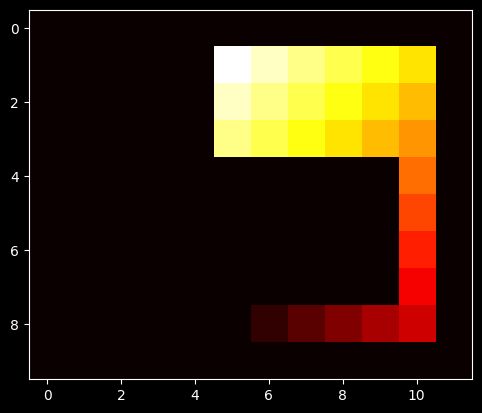

In [24]:
def text_print_pos_map(_pos_map):
    for row in _pos_map:
        print(' '.join(x_size*['{}']).format(*[str(int(r)).zfill(3) for r in row]))

def plot_pos_map(_pos_map):
    plt.imshow(_pos_map, cmap='hot', interpolation='nearest')
    plt.show()

# calculate minimum value with respect to velocities
x_size, y_size = len(course[0]), len(course)
pos_map = np.zeros((y_size, x_size))

for s_x in range(x_size):
    for s_y in range(y_size):
        pos_map[s_y, s_x] = np.min(values[s_y, s_x, :, :])

text_print_pos_map(pos_map)
plot_pos_map(-pos_map)

## 2) On-Policy $\varepsilon$-Greedy Control

Starting with the previously used turn-right-if-wall dummy policy, write an on-policy Monte-Carlo based first-visit $\varepsilon$-greedy control algorithm to solve the U-turn course. The policy is now stochastic: it does not contain simple action commands for each state, but probabilities for each possible action. Again, please make sure to understand how the stochastic policy works before coding.


Make sure to implement an upper bound for episode length (we suggest a boundary of 200 steps). Why do we need a bound like this? What happens to the state values / state-action values if we increase the bound?

In [25]:
# dummy policy
course = build_uturn_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)

dummy_slow_stoch_pi = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 9])

dummy_slow_stoch_pi[  :,   :, :, :, 4] = 1 # set probability of doing nothing to one for every state

# set probability to accelerate right:
dummy_slow_stoch_pi[:track.bounds[0]//2, :, 0 , 0, 5] = 1
# set probability to do nothing where we want to accelerate right:
dummy_slow_stoch_pi[:track.bounds[0]//2, :, 0 , 0, 4] = 0

dummy_slow_stoch_pi[:track.bounds[0]//2, -2:, 0 , :, 6] = 1 # probability to accelerate bottom left
dummy_slow_stoch_pi[:track.bounds[0]//2, -2:, 0 , :, 4] = 0

dummy_slow_stoch_pi[-2:, track.bounds[1]//2:, : , 0, 0] = 1 # probability to accelerate top left
dummy_slow_stoch_pi[-2:, track.bounds[1]//2:, : , 0, 4] = 0

pi = dummy_slow_stoch_pi

## 2) Solution

Algorithm given below.

As we can see, the dummy policy allows for the initial episode to be solved very fast. After that, the dummy policy is forgotten and it takes some time until the agent is able to solve the problem again.

The limitation of the episode length forces the agent to learn at least after the allowed number of steps were taken. If one would increase the limit, this would mainly inflate the accumulated return, resulting in larger negative action values for the visited states. As long as we do NOT find the goal, action values will correlate with the time limit. If we find the goal reproducible, the action values will drift towards their true optimal value independently from the time limit.

If we do not implement a time limit and allow the episode to terminate only by reaching the goal, the accumulated negative return will explode (we will get very large numbers). As we try to act greedy (take the highest rated and not the lowest rated action), low action values would suggest that the goal is not to be found on the path taken previously.

In [26]:
# function templates, some of these are quite close to the solutions for task 1

def policy(pi, state, deterministic, epsilon):
    """Decides on one of the actions in dependence of the current state.

    Args:
        pi: The current policy
        state: The state vector
        deterministic: Whether actions are chosen deterministically or eps-greedily
        epsilon: Probability for random action in eps-greedy

    Returns:
        action: The chosen action
    """
    ### BEGIN SOLUTION

    if epsilon < np.random.rand(1) or deterministic:
        action = np.argmax(pi[state])
    else:
        action = random.choice(range(9))

    action = track.action_to_tuple(action)

    ### END SOLUTION
    return action


def interact(pi, state, deterministic, epsilon):
    """Interact with the environment to get to the next state. Either follow
    the given policy or explore randomly with probability epsilon.

    Args:
        pi: The policy to follow
        state: The current state before interaction
        deterministic: Whether actions are chosen deterministically or eps-greedily
        epsilon: The probability for random interaction

    Returns:
        next_state: The next state after interaction
        reward: The reward for the current interaction
        terminated: If the goal was reached
        truncated: If the boundary of the track was breached
        action: The applied action
    """
    ### BEGIN SOLUTION

    action = policy(pi, state, deterministic, epsilon)

    next_state, reward, terminated, truncated, _ = track.step(action)

    ### END SOLUTION
    return next_state, reward, terminated, truncated, action


def gather_experience(pi, max_episode_len, deterministic=False, epsilon=0.1):
    """Simulate a full episode of data by repeatedly interacting with the environment.

    End the episode when the finish line is reached. Whenever the car leaves the track, simply
    reset the environment.

    Args:
        pi: The policy to apply
        max_episode_len: The number of steps at which the episode is terminated automatically
        deterministic: Whether actions are chosen deterministically or eps-greedily
        epsilon: Exploration probability

    Returns:
        state_actions: All states that were visited and all actions that were applied in
            the episode, states and actions are simply concatenated. **HINT**: You can use
            ```track.state_action(state, action)``` to concatenate state and action.
        rewards: All rewards that were acquired in the episode
        visited_states: The unique states that were visited in the episode
        first_visit_list: Whether it was the first time in the episode that the
            state at the same index was visited
        pos_map: A map of the track where all state visits are marked
    """

    # initialize variables in which collected data will be stored
    state_actions = [] # list of tuples
    rewards = [] # list of floats
    visited_state_actions = set() # set of tuples
    first_visit_list = [] # list of booleans

    pos_map = np.zeros((y_size, x_size)) # initializes a map that can be plotted

    ### BEGIN SOLUTION

    state = track.reset()
    for k in range(max_episode_len):

        pos_map[state[0], state[1]] += 1  # mark the visited position on the map

        next_state, reward, terminated, truncated, action = interact(pi, state, deterministic, epsilon)

        # save the momentary state+action and check for first_visit
        state_action = track.state_action(state, action)
        state_actions.append(state_action)
        first_visit_list.append(state_action not in visited_state_actions)
        visited_state_actions.add(state_action)

        if truncated:
            next_state = track.reset()

        state = next_state

        # save received reward
        rewards.append(reward)

        # terminate the environment if the finish line was passed
        if terminated:
            break

    ### END SOLUTION
    return state_actions, rewards, visited_states, first_visit_list, pos_map


def learn(pi, action_values, n_dict, state_actions, rewards, first_visit_list, gamma, epsilon):
    """Learn from the collected data with eps-greedy MC-control and update the policy.

    Args:
        pi: The policy before the update step
        action_values: The action-value estimates before the current update step
        n_dict: The state action visit counts before the update
        state_actions: All state actions that were done in the last epsiode
        rewards: All rewards that were visited in the last episode
        first_visit_list: Whether it was the first time in the episode that the
            state at the same index was visited
        gamma: Discount factor
        epsilon: Exploration probability

    Returns:
        pi: The updated policy
        action_values: The updated action-value estimates
        n_dict: The updated state action visit counts

    """
    ### BEGIN SOLUTION

    g = 0
    for reward, state_action, first_visit in zip(rewards[::-1], state_actions[::-1], first_visit_list[::-1]): # count backwards
        g = gamma * g + reward

        if first_visit:

            # Count visits to this state in n_list
            n_dict[state_action] = n_dict.get(state_action, 0) +  1

            # add new return g to existing value
            action_values[state_action] += 1/n_dict[state_action] * (g - action_values[state_action])

            # calculate the new action probabilities
            u_best = np.argmax(action_values[state_action[:4]])
            pi[state_action[:4]] = epsilon / 9
            pi[state_action[:4]][u_best] = 1 - epsilon + epsilon / 9

    ### END SOLUTION
    return pi, action_values, n_dict

In [27]:
# initialize action_values and counting dict
action_values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 3, 3])
n_dict = {}

# configuration parameters
epsilon = 0.1 # exploration probability
gamma = 1 # discount factor
no_episodes = 5000 # number of evaluated episodes
max_episode_len = 200 # number of evaluated timesteps per episode
track_maps_l = []  # placeholder for tracks

track = RaceTrackEnv(course)
x_size, y_size = len(course[0]), len(course)

for e in tqdm(range(no_episodes), desc='episode', mininterval=2):

    state_actions, rewards, visited_states, first_visit_list, pos_map = gather_experience(pi, max_episode_len, epsilon)

    pi, action_values, n_dict = learn(pi, action_values, n_dict, state_actions, rewards, first_visit_list, gamma, epsilon)

    # optional value map logging
    track_maps_l.append(track.course + (pos_map > 0).astype(np.float32))

episode:   0%|          | 0/5000 [00:00<?, ?it/s]

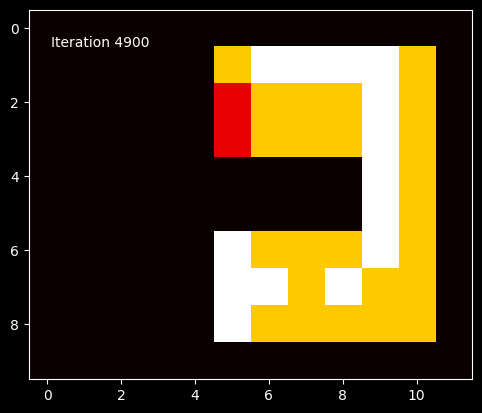

In [28]:
# animate visited tracks
fig, ax = plt.subplots()
image = plt.imshow(track.course, cmap='hot', interpolation='none')
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def get_render_func(_track_maps_l):
    def animate(it):
        track_map = _track_maps_l[it]
        #image.set_array(track.course)
        image.set_array(track_map)
        time_text.set_text(f"Iteration {it}")
        return image, time_text
    return animate

def init():
    image.set_array(track.course)
    return [image]

ani = animation.FuncAnimation(fig, get_render_func(track_maps_l), frames=range(0, len(track_maps_l), 100),
                              interval=100, blit=True, init_func=init)
ani.save("solution_2.gif")


![SegmentLocal](solution_2.gif "segment")

Use the code block directly below to test the resulting deterministic greedy policy (several samples are taken in order to show behavior in all different starting positions).

In [29]:
pos_maps_over_eps_l = []
no_episodes = 10
for e in range(no_episodes):

    _, _, _, _, pos_map = gather_experience(pi, max_episode_len, deterministic=True)
    pos_map = (pos_map > 0).astype(np.int16)
    pos_map +=  track.course  # overlay track course
    pos_maps_over_eps_l.append(pos_map)


ani = animation.FuncAnimation(fig, get_render_func(pos_maps_over_eps_l),
                              frames=range(0, len(pos_maps_over_eps_l), 1),
                              interval=500, blit=True, init_func=init)
ani.save("solution_2_2.gif")

![SegmentLocal](solution_2_2.gif "segment")

## 3) Extra Challenge: A More Complex Course

The track given below poses a substantially harder challenge for Monte-Carlo based algorithms. Why? If you want to try solving it yourself, be aware that it may take much longer until a successful policy is found.

In [30]:
from utils import build_rect_course

WWWWWWWWWWWW
Woooo+W-oooW
Woooo+W-oooW
Woooo+W-oooW
WooWWWWWWooW
WooWWWWWWooW
WooooooooooW
WooooooooooW
WooooooooooW
WWWWWWWWWWWW


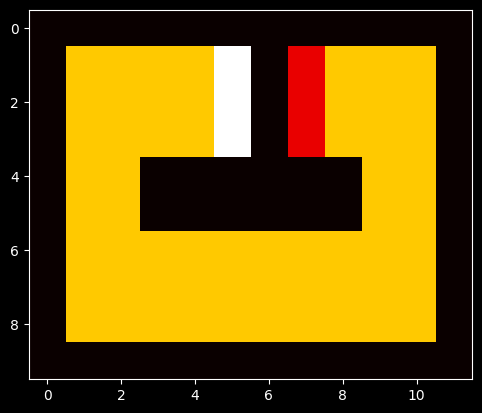

In [31]:
# Build the course
_course_dim = (8, 10)
_inner_wall_dim = (2, 6)

course = build_rect_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)
for row in course:
    print(row)

pos_map =  track.course  # overlay track course
plot_pos_map(pos_map)

## 3) Solution

Taking four turns to reach the goal is way harder than taking just two turns. Additionally, the state space is a lot larger now, which leads to much more exploration being necessary until all the states are properly evaluated. Although the course is more complicated, the problem description ("reach the goal") and the evironment physics (acceleration, momentum and collision) are still the same. Thus, there is no fundamental reason why Monte-Carlo should not be successful here, we just have to be aware that it will take some time.

Fortunately, there are still upcoming lectures where more efficient learning algorithms could be discussed ;)

The following screenshot was taken after trying to solve this problem with the same algorithm as presented in task 2). As can be seen, the agent is actually able to solve the racetrack and reach the finish line. But it took about six hours on a very powerful computer to do so.

![](FullCourse_MonteCarlo_Solved.png)
